### Exercise 1

The court case: the blue or green cab.
A cab was involved in a hit and run accident at night. There are two cab companies in the town: blue and green. The former has 150 cabs, and the latter 850 cabs. A witness said that a blue cab was involved in the accident; the court tested his/her reliability under the same circumstances, and got that 80% of the times the witness correctly identified the color of the cab. what is the probability that the color of the cab involved in the accident was blue given that the witness said it was blue?

### Exercise 2

The Monty Hall problem
What is the probability of winning a car in the Monty Hall problem switching the decision if there are four doors, where there are three goats and one car? Solve this problem analytically and computationally. What if there are $n$ doors, $n − 1$ goats and one car?

In [26]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(777)

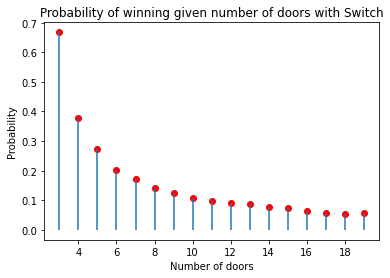

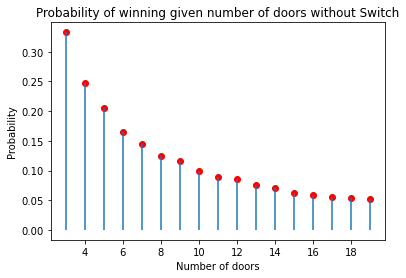

In [2]:
def monty_hall(n_doors: int, switch: bool):

    """Simulates Monty Hall problem"""

    # Assign car to random door
    car_index = np.random.randint(0, n_doors)

    # Door pick
    door_index = np.random.randint(0, n_doors)

    # Assign door that Monty Opens
    monty_index = np.random.randint(0, n_doors)

    while monty_index == car_index or monty_index == door_index:
        monty_index = np.random.randint(0, n_doors)

    if switch:
        # Assign door to which we switched to/final pick
        final_pick_index = np.random.randint(0, n_doors)

        while final_pick_index == monty_index or final_pick_index == door_index:
            final_pick_index = np.random.randint(0, n_doors)

        door_index = final_pick_index

    return 1 if door_index == car_index else 0

def monty_hall_iterator(n_doors: int, switch: bool = True,
                num_iter: int = 10000, verbose: int = -1) -> None:

    """Simulates the Monty Hall problem a num_iter of times and extracts the probability of winning
    given the switch decision.

    Args:
        n_doors (int): Number of doors to choose from.
        switch (bool): Whether to switch door or not.
        num_iter (int): Number of times to simulate the problem.

    Return:
        Probability of winning given the decision and number of iterations."""

    counter = 0

    for _ in range(num_iter):
        counter += monty_hall(n_doors, switch)

    winning_probability = counter/num_iter

    print_switch = 'switching' if switch else 'not switching'

    if verbose > 0:
        print(f'The probability of winning is {winning_probability} given {n_doors} doors, {print_switch} doors, and simulating {num_iter} times.')

    return winning_probability

def monty_hall_probability_graph(num_iter: float = 10000) -> None:

    """Plot probability of winning against number of doors."""

    n_doors = [i for i in range(3, 20)]
    switch_winning_probability = [monty_hall_iterator(doors) for doors in n_doors]

    for doors, prob in zip(n_doors, switch_winning_probability):
        plt.vlines(x=doors, ymin=0, ymax=prob)
    plt.scatter(n_doors, switch_winning_probability, c='r')
    plt.xlabel('Number of doors')
    plt.ylabel('Probability')
    plt.title('Probability of winning given number of doors with Switch')

    plt.figure()

    nonswitch_winning_probability = [monty_hall_iterator(doors, switch=False) for doors in n_doors]

    for doors, prob in zip(n_doors, nonswitch_winning_probability):
        plt.vlines(x=doors, ymin=0, ymax=prob)
    plt.scatter(n_doors, nonswitch_winning_probability, c='r')
    plt.xlabel('Number of doors')
    plt.ylabel('Probability')
    plt.title('Probability of winning given number of doors without Switch')

monty_hall_probability_graph()

### Excercise 3

Solve the health insurance example using a Gamma prior in the rate parametrization, that is,

$$
\pi(\lambda) = \frac{\beta_{0}^{\alpha_{0}}}{\Gamma(\alpha_{0})}\lambda^{\alpha_{0} - 1}exp\{-\lambda\beta_{0}\}
$$

In [47]:
import typing as t
import numpy as np
from scipy.special import loggamma, comb
from scipy.optimize import minimize

In [84]:
# Define list with doctor visits data
y = [0, 3, 2, 1, 0]
N_SAMPLES = len(y)
SUM_Y = sum(y)

sample_mean = np.mean(y)
sample_variance = np.var(y, ddof=1)

print(f'The sample mean is: {sample_mean}\nThe variance is {sample_variance}')

The sample mean is: 1.2
The variance is 1.7000000000000002


In [91]:
def get_gamma_mean(alpha: float, beta: float) -> float:
    """Returns the mean of a gamma distribution."""
    return alpha / beta

def get_gamma_variance(alpha: float, beta: float) -> float:
    """Returns the variance of a gamma distribution."""
    return alpha / (beta ** 2)

def probability_of_going_to_the_doctor(alpha_0: float, beta_0: float) -> float:

    """Returns the probability of going to the doctor at least once given that y distributes Poisson
    with parameter lambda, and that lambda distributes Gamma with alpha_0 and beta_0 as scale and
    rate parameters.

    Args:
        alpha_0 (float): Scale parameter of Gamma distribution.
        beta_0 (float): Rate parameter of Gamma distribution.

    Return:
        float: Probability of going to the doctor at least once."""

    alpha_n = alpha_0 + SUM_Y
    beta_n = beta_0 + N_SAMPLES
    p = beta_n / (beta_n + 1)

    return 1 - pow(p, alpha_n)

# Using vague prior
alpha_0 = 0.001
beta_0 = 0.001

vague_prior_probability = probability_of_going_to_the_doctor(alpha_0, beta_0)

print(f'The probability of visiting the Doctor at least once next year using a vague prior is {vague_prior_probability}')

print(f'The mean of the Gamma distribution is {get_gamma_mean(alpha_0, 1/beta_0)}')
print(f'The variance of the Gamma distribution is {get_gamma_variance(alpha_0, 1/beta_0)}')

The probability of visiting the Doctor at least once next year using a vague prior is 0.6650961039085583
The mean of the Gamma distribution is 1e-06
The variance of the Gamma distribution is 1e-09


In [80]:
def log_marginal_likelihood(theta: t.Iterable) -> float:

    """Returns the Marginal Likelihood of the data given theta as the scale and rate parameters of
    the Gamma distribution.

    Args:
        theta (Iterable): Scale and rate parameters of Gamma distribution.

    Return:
        float: Marginal Likelihood of the data given theta."""

    alpha_0, beta_0 = theta[0], theta[1]

    if alpha_0 <= 0 or beta_0 <= 0:
        return -np.inf

    alpha_n = SUM_Y + alpha_0
    beta_n = N_SAMPLES + beta_0
    likelihood = loggamma(alpha_n) - loggamma(alpha_0) + alpha_0*np.log(beta_0) - alpha_n*np.log(beta_n)

    return -likelihood

theta0 = [0.01, 0.01]
empirical_bayes =  minimize(log_marginal_likelihood, theta0, method='L-BFGS-B', options={'maxiter':1000})

print(f'Did the optimizer succeed? -> {empirical_bayes.success}')

alpha_0_hat, beta_0_hat = empirical_bayes.x

print(f'The alpha_0_hat is {alpha_0_hat} and the beta_0_hat is {beta_0_hat}')

empirical_bayes_probability = probability_of_going_to_the_doctor(alpha_0_hat, beta_0_hat)

print(f'The probability of visiting the Doctor at least once next year using Empirical Bayes is {empirical_bayes_probability}')

print(f'The mean of the Gamma distribution is {get_gamma_mean(alpha_0_hat, beta_0_hat)}')
print(f'The variance of the Gamma distribution is {get_gamma_variance(alpha_0_hat, beta_0_hat)}')

Did the optimizer succeed? -> True
The alpha_0_hat is 1554.387381053294 and the beta_0_hat is 3340.595247571879
The probability of visiting the Doctor at least once next year using Empirical Bayes is 0.37201518747896256
The mean of the Gamma distribution is 0.4653025182212974
The variance of the Gamma distribution is 0.00013928730772143195


### Exercise 4

Suppose that you are analyzing to buy a car insurance next year. To make a better decision you want to know what is the probability that you have a car claim next year? You have the records of your car claims in the last 15 years, $y = \{0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0\}$.

Assume that this is a random sample from a data generating process (statistical model) that is binomial, $Y_{i} \sim Bin(p)$, and your probabilistic prior beliefs about $p$ are well described by a beta distribution with parameters $\alpha_{0}$ and $\beta{0}$, $p \sim B(\alpha_{0}, \beta_{0})$, then, you are interested in calculating the probability of a claim the next year $P(Y_0 = 1)|y)$.

Solve this using an empirical Bayes approach and a non-informative approach where $\alpha_0 = \beta_0 = 1$ (uniform distribution).

In [9]:
import typing as t

from scipy.stats import betabinom
from scipy.special import betaln
from scipy.optimize import minimize

In [20]:
# Data points
y = [0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]
N_SAMPLES = len(y)
SUM_Y = sum(y)
mean_y = np.round(np.mean(y), 2)
var_y = np.round(np.var(y, ddof=1), 2)

print(f'The number of samples is {N_SAMPLES}')
print(f'The mean of the samples is {mean_y}')
print(f'The variance of the samples is {var_y}')

The number of samples is 15
The mean of the samples is 0.47
The variance of the samples is 0.27


In [11]:
def get_beta_mean(alpha: float, beta: float) -> float:
    """Returns the mean of a beta distribution."""
    return alpha / (alpha + beta)

def get_beta_variance(alpha: float, beta: float) -> float:
    """Returns the variance of a beta distribution."""
    return alpha * beta / ((alpha + beta) ** 2 * (alpha + beta + 1))

def probability_of_claiming_car(alpha_0: float, beta_0: float) -> float:

    """Returns the probability of claiming a car given that y distributes binomial with probability
    p, which distrbutes Beta(alpha_0, beta_0). The probablity is given by the posterior BetaBinomail
    distribution with parameters alpgha_n and beta_n.

    Args:
        alpha_0 (float): Prior shape parameter.
        beta_0 (float): Prior rate parameter.

    Returns:
        float: Probability of claiming a car."""

    alpha_n = SUM_Y + alpha_0
    beta_n = N_SAMPLES - SUM_Y + beta_0
    return betabinom.pmf(1, 1, alpha_n, beta_n)

alpha_0 = 1
beta_0 = 1
vague_probability = probability_of_claiming_car(alpha_0, beta_0)

print(f'Considering a non-informative approach, were alpha_0 = {alpha_0} and beta_0 = {beta_0}')
print(f'The probability of claiming a car is {vague_probability}')

print(f'The mean of the Beta distribution is {get_beta_mean(alpha_0, beta_0)}')
print(f'The variance of the Beta distribution is {get_beta_variance(alpha_0, beta_0)}')

Considering a non-informative approach, were alpha_0 = 1 and beta_0 = 1
The probability of claiming a car is 0.4705882352941173
The mean of the Beta distribution is 0.5
The variance of the Beta distribution is 0.08333333333333333


In [12]:
def log_marginal_likelihood(theta: t.Iterable) -> float:

    """Returns the log marginal likelihood value of the data given the parameters alpha_0 and beta_0.

    Args:
        theta (Iterable): Scale and rate parameters of Beta distribution.

    Returns:
        float: Log marginal likelihood value."""

    alpha_0, beta_0 = theta[0], theta[1]

    if alpha_0 <= 0 or beta_0 <= 0:
        likelihood = -np.inf

    alpha_n = SUM_Y + alpha_0
    beta_n = N_SAMPLES - SUM_Y +beta_0
    likelihood = betaln(alpha_n, beta_n) - betaln(alpha_0, beta_0)
    return -likelihood

theta0 = [0.1, 0.1]
empirical_bayes =  minimize(log_marginal_likelihood, theta0, method='L-BFGS-B', options={'maxiter':1000})

print(f'Did the optimizer succeed? -> {empirical_bayes.success}')

alpha_0_hat, beta_0_hat = empirical_bayes.x

print(f'The alpha_0_hat is {alpha_0_hat} and the beta_0_hat is {beta_0_hat}')


empirical_bayes_probability = probability_of_claiming_car(alpha_0_hat, beta_0_hat)

print(f'Considering a Empirical Bayes, were alpha_0 = {alpha_0} and beta_0 = {beta_0}')
print(f'The probability of claiming a car is {empirical_bayes_probability}')

print(f'The mean of the Beta distribution is {get_beta_mean(alpha_0_hat, beta_0_hat)}')
print(f'The variance of the Beta distribution is {get_beta_variance(alpha_0_hat, beta_0_hat)}')

Did the optimizer succeed? -> True
The alpha_0_hat is 352.59050327275975 and the beta_0_hat is 404.3160828940399
Considering a Empirical Bayes, were alpha_0 = 1 and beta_0 = 1
The probability of claiming a car is 0.46584717596250064
The mean of the Beta distribution is 0.46583093570156797
The variance of the Beta distribution is 0.00032831549373844176
